In [1]:
%run init_notebook.py

In [152]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby
import scipy

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [5]:
import scipy

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson


from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.vector_ar.vecm import select_order

from statsmodels.iolib.summary2 import summary_col

In [5]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

In [6]:
from src.utils import get_stars

In [182]:
type(m_fe)

linearmodels.panel.results.PanelEffectsResults

In [188]:
def min_max_scale(x):
    return (x - x.min())/(x.max() - x.min())

from statsmodels.regression.linear_model import RegressionResultsWrapper
from statsmodels.tsa.vector_ar.vecm import VECMResults
from linearmodels.panel.results import PanelEffectsResults

def _get_statsmodels_ols_summary(mod):
    df = pd.DataFrame(pd.concat([mod.params, mod.pvalues, mod.tvalues], axis=1))
    df.columns = ['coef', 'pval', 'stat']
    
    df_conf = mod.conf_int()
    df_conf.columns = ['conf_lower', 'conf_upper']
    
    endog_name = mod.model.endog_names
    df = df.join(df_conf)
    return df, endog_name

def _get_linearmodels_pols_summary(mod):
    df = pd.DataFrame(pd.concat([mod.params, mod.pvalues, mod.tstats], axis=1))
    df.columns = ['coef', 'pval', 'stat']
    
    df_conf = mod.conf_int()
    df_conf.columns = ['conf_lower', 'conf_upper']
    
    endog_name = str(mod.model.dependent.dataframe.columns[0])
    df = df.join(df_conf)
    
    return df, endog_name

def _get_statmodels_vecm_summary(mod, endog_index: 0):
    endog_name = mod.model.endog_names[endog_index]
    
    df = pd.DataFrame(mod.summary().tables[0].data).iloc[1:].set_index(0)
    df.index.name = ''
    df.columns = ['coef', 'stderr', 'stat', 'pval', 'conf_lower', 'conf_upper']
    df = df.astype(float)
    
    return df[['coef', 'pval', 'stat', 'conf_lower', 'conf_upper']], endog_name
    

def get_statsmodels_summary(lst_mods, col_out: str = 'print', vecm_endog_index: int = 0, seperator: str = "\n"):
    lst_dfs = []
    endog_name_save = ""
    for idx, mod in enumerate(lst_mods):
        
        if type(mod) == RegressionResultsWrapper:
            df, endog_name = _get_statsmodels_ols_summary(mod)
            
        elif type(mod) == VECMResults:
            df, endog_name = _get_statmodels_vecm_summary(mod, vecm_endog_index)
            
        elif type(mod) == PanelEffectsResults:
            df, endog_name = _get_linearmodels_pols_summary(mod)
            
        else:
            raise KeyError(f"{type(mod)} not specified")
            
        if endog_name == endog_name_save:
                endog_name += f"_{idx}"
        endog_name_save = endog_name
    
        # layout
        df['star'] = df['pval'].apply(lambda x: get_stars(x))
        df['print'] = df.coef.round(3).astype(str) + " " + df.star.astype(str) + seperator + "[" + df.stat.round(3).astype(str) + "]"
        
        cols = [list(df.columns), list([endog_name] * df.shape[1])]
        df.columns = pd.MultiIndex.from_tuples(list(map(tuple, zip(*cols))))

        lst_dfs.append(df)

        out = pd.concat([df[col_out] for df in lst_dfs], axis=1, join='outer')

    return out


def get_fig_subplots(n_plots: int, n_cols: int = 2, figsize: tuple =(6,3.5), **kwargs):
    n_rows = int(np.ceil(n_plots/n_cols))
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(figsize[0] * n_rows, figsize[1] * n_cols), **kwargs)
    if n_plots == 1 and n_cols == 1:
        return fig, ax 
    else:
        ax = ax.ravel()[:n_plots]
    return fig, ax
    
def get_multiple_vecm_irfs(lst_vecms, idx_vecm: tuple = (0,1), dict_titles: dict = None, **kwargs):
    fig, axes = get_fig_subplots(len(lst_vecms), **kwargs)
    for idx, ax in enumerate(axes):
        irf = lst_vecms[idx].irf()
        
        ax.plot(irf.irfs[:, *idx_vecm], color='blue', label='irf')
        ax.fill_between(range(len(irf.irfs)), 
                        irf.irfs[:, idx_vecm[0], idx_vecm[1]] + 1.96 * irf.stderr()[:, idx_vecm[0], idx_vecm[1]],
                        irf.irfs[:, idx_vecm[0], idx_vecm[1]] - 1.96 * irf.stderr()[:, idx_vecm[0], idx_vecm[1]],
                        alpha=.3, color='grey', linestyle='dashed', label='90% conf.')

        ax.plot(list([0] * irf.irfs.shape[0]), color='black')
        
        n1, n2 = lst_vecms[idx].names[idx_vecm[1]], lst_vecms[idx].names[idx_vecm[0]]
        # print(v.names)
        if dict_titles is not None:
            try:
                n1 = dict_titles[n1]
                n2 = dict_titles[n2]
            except Exception as e:
                n1, n2 = lst_vecms[idx].names[idx_vecm[1]], lst_vecms[idx].names[idx_vecm[0]]
            
        ax.set_title(f"{n1} -> {n2}",)
        ax.legend()
    
    fig.tight_layout()
    return fig

# load data

In [8]:
topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
topics.set_index('date', inplace=True)

topics_raw = topics[[i for i in topics.columns if "_W" not in i and "_diff" not in i]].copy().drop(['M_policy', 'id',], axis=1)

topics = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]]
topics.columns = [i.split("_W")[0] for i in topics.columns]
topics = topics.join(topics.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics['T_sum_diff_lag'] = topics.T_sum.drop_duplicates().diff().shift(1)
topics = topics.drop_duplicates()

hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

pi = load_pd_df("pi.feather")
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [9]:
df = hhp.set_index('date_recorded')[
    [
        'pi_perc', 'id', 'hhinc', 'hhinc_delta', 'hhinc_midpoint', 'delta_pe', 'delta_pe_WY', 'delta_pe_MY', 'pi_perc_MY', 
        'pi_perc_WY', 'percprob_war',
        'percprob_covid', 'date_forecast',  'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust',
        'pi_perc95_MY', 'pi_perc05_MY', 'pi_perc05_WY', 'pi_perc95_WY',
        'pi_exp_MY', 'i_exp_MY', 'pi_exp_WY', 'riskaversion'
    ]].drop_duplicates().copy()
df = pd_join_dfs([df, hhp.set_index('date_forecast')[
    ['pi_exp_MY', 'i_exp_MY', 'pi_exp975_MY', 'pi_exp975_WY', 'pi_exp025_MY', 'pi_exp025_WY', 'pi_exp_WY']
].drop_duplicates().add_suffix("_F"),],
                 index_name='date_recorded')

In [10]:
df['pi_exp_uncertainty_WY_F'] = df['pi_exp975_WY_F'] - df['pi_exp025_WY_F']
df['pi_perc_uncertainty_WY'] = df['pi_perc95_WY'] - df['pi_perc05_WY']

df['pi_exp_uncertainty_MY_F'] = df['pi_exp975_MY_F'] - df['pi_exp025_MY_F']
df['pi_perc_uncertainty_MY'] = df['pi_perc95_MY'] - df['pi_perc05_MY']

In [11]:
df = pd_join_freq(df, topics, "W", True)
df = pd_join_freq(df, mir[['ecb_rate']], "M", True)
df = pd_join_freq(df, pi[['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y']], 'M', True)

df['week_recorded'] = df.index.to_period('W').to_timestamp()
df['week_forecast'] = df.date_forecast.dt.to_period('W').dt.to_timestamp()
df['month_recorded'] = df.date_recorded.dt.to_period('M').dt.to_timestamp()
df = df.reset_index(drop=True)

In [12]:
# check

In [13]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    49546.000000
mean         1.937573
std          1.801603
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64

## plot time series inflation

In [14]:
sub = pd_groupby(df.set_index('date_recorded'),
           ['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY', 'pi_exp_MY', 'pi_perc95_MY', 'pi_perc05_MY'],
           "M", 'last').dropna()
sub2 = pd_groupby(df.set_index('date_forecast'), 
                  ['pi_de_Y', 'pi_exp975_MY_F', 'pi_exp025_MY_F', 'pi_de_estimate_Y', 'pi_exp_MY_F'], 'M', 'last').dropna()

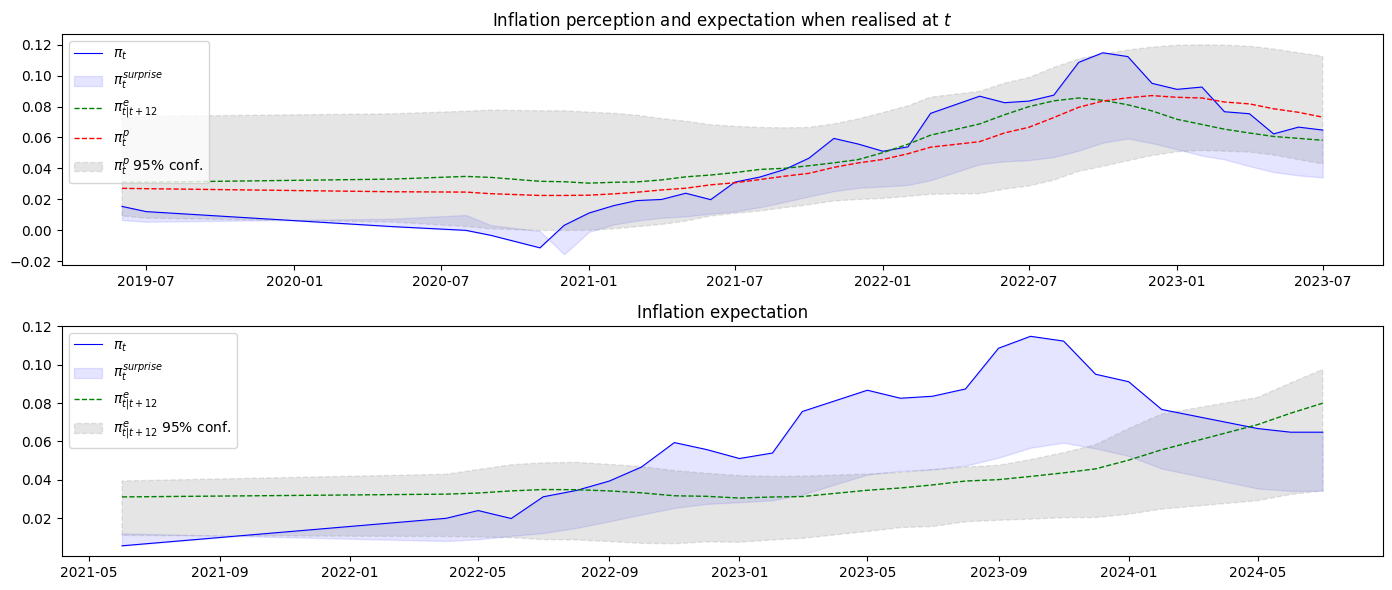

In [15]:
fig, ax = plt.subplots(2,1, figsize=(14,6))

ax[0].plot(sub['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[0].fill_between(sub.index, sub['pi_de_estimate_Y'], sub['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)

ax[0].plot(sub['pi_exp_MY'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[0].plot(sub['pi_perc_MY'], linestyle='dashed', color='red', lw=1, label=r'$\pi^p_{t}$')
ax[0].fill_between(sub.index, sub['pi_perc95_MY'], sub['pi_perc05_MY'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^p_{t}$ 95% conf.')

ax[0].set_title('Inflation perception and expectation when realised at $t$', size=12)
ax[0].legend(loc='upper left', )

ax[1].plot(sub2['pi_de_Y'], color='blue', lw=.8, label='$\pi_t$')
ax[1].fill_between(sub2.index, sub2['pi_de_estimate_Y'], sub2['pi_de_Y'], color='blue', alpha=.1, label="$\pi^{surprise}_t$",)
ax[1].plot(sub2['pi_exp_MY_F'], color='green', linestyle='dashed', lw=1, label=r'$\pi^e_{t|t+12}$')
ax[1].fill_between(sub2.index, sub2['pi_exp975_MY_F'], sub2['pi_exp025_MY_F'], color='grey', linestyle='dashed',
                alpha=.2, label='$\pi^e_{t|t+12}$ 95% conf.')
ax[1].set_title("Inflation expectation", size=12)
ax[1].legend()

fig.tight_layout()

save_fig(fig, 'plot_inflation.png')

# Cross Section Expectation and perception

In [16]:
# get pi percption error
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], agg_col_suffix='all', count_thresh=1)
df = get_individual_perc_error(df, 'pi_perc_MY', pi[['pi_de_Y']], count_thresh=6)
df = get_individual_perc_error(df, 'delta_pe_MY', pi[['pi_de_Y_diff']], ind_cols=['date_forecast', 'id'], count_thresh=5)
df = get_individual_perc_error(df, 'pi_exp_MY', pi[['pi_de_Y']], ind_cols=['date_forecast', 'id'], count_thresh=5)

In [17]:
lst_error_cols = sorted([i for i in df.columns if "_error" in i and "mse" not in i and 'all' not in i])
lst_error_cols

['delta_pe_MY_error_act', 'pi_exp_MY_error_act', 'pi_perc_MY_error_act']

In [18]:
for col in lst_error_cols:
    print(col, df[['id', col]].drop_duplicates().dropna().shape)
    # plt.hist(df[['id',col]].drop_duplicates().dropna().iloc[:, 1])

delta_pe_MY_error_act (10748, 2)
pi_exp_MY_error_act (10976, 2)
pi_perc_MY_error_act (9130, 2)


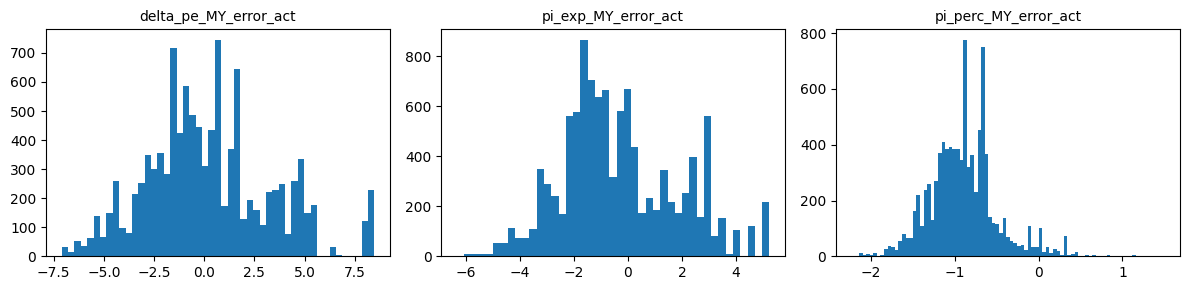

In [19]:
fig, axes = plt.subplots(1,3,)
for i, ax in enumerate(axes.ravel()):
    ax.set_title(lst_error_cols[i], size=10)
    ax.hist(df[['id', lst_error_cols[i]]].drop_duplicates().drop('id', axis=1).dropna(), bins='fd')

fig.tight_layout();
save_fig(fig, 'emp_error_hist.png')

In [20]:
_ = df.set_index('id')[lst_error_cols].drop_duplicates()
ols_data = hhp[
    [
        'is_food_shop',  
        'pinc_midpoint', 
        'hhinc_midpoint',
        # 'hhinc',
        # 'debt_midpoint',
        # 'wealth_bank_midpoint', 
        # 'savings_planned', 
        # 'profession_txt',
        # 'ecbtrust',
        # 'pr
        # 'hhsize',
        'riskaversion',
        'hhchildren', 
        # 'is_invest_shop', 
        # 'is_unempl', 
        # 'is_cash_pay',
        # 'is_homeown', 
        'id',
    ]].set_index('id').loc[_.index].copy()
ols_data = ols_data.join(_).reset_index().groupby('id').last()
ols_data2 = ols_data.copy()

In [21]:
DICT_PARSE_COLS.update(
    {
        'hhsize': 'categoryO', 'hhinc_midpoint': 'categoryO', 'pinc_midpoint': 'categoryO', 'profession_txt': 'category',
        'riskaversion': 'categoryO'
    }
)
DICT_PARSE_COLS.update({i: float for i in lst_error_cols})
ols_data = pd_df_astype(ols_data, DICT_PARSE_COLS)

In [22]:
dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'category':
        dummies = pd.get_dummies(ols_data[col], dtype=bool)
        dummies = dummies.add_prefix(col)
        ols_data = ols_data.join(dummies.iloc[:, :])
        ols_data = ols_data.drop(col, axis=1)
        
ols_data['const'] = np.ones(len(ols_data))
ols_data = ols_data.drop_duplicates().astype(float)

In [23]:
# multiple ols models
lst_ols_mods = []
for col in lst_error_cols:
    d = ols_data.drop([i for i in lst_error_cols if i != col], axis=1)
    d = d.dropna()
    print(d.shape)
    ols = OLS(
        d[col], 
        d.drop(col, axis=1),
        hasconst=True,
    ).fit()
    lst_ols_mods.append(ols)

(3282, 42)
(3397, 42)
(2568, 42)


In [24]:
summary_col(lst_ols_mods, stars=True)

,delta_pe_MY_error_act,pi_exp_MY_error_act,pi_perc_MY_error_act
is_food_shop,-0.1517,0.0313,0.1145***
,(0.2063),(0.1395),(0.0415)
pinc_midpoint250.0,0.0355,0.0163,0.0432
,(0.6130),(0.4290),(0.1234)
pinc_midpoint750.0,-0.0531,0.1456,-0.0009
,(0.5946),(0.4166),(0.1184)
pinc_midpoint1250.0,-0.0927,0.1685,0.1314
,(0.5806),(0.4068),(0.1156)
pinc_midpoint1750.0,-0.3325,-0.0739,0.0540
,(0.5798),(0.4066),(0.1154)


In [27]:
_ = get_statsmodels_summary(lst_ols_mods)
save_pd_df(_, 'tab_cross_section_error.csv', GRAPHS_DIR)

## risk aversion delta_pe

In [28]:
sub2 = get_statsmodels_summary(lst_ols_mods, ['conf_upper', 'conf_lower', 'coef']).copy()
sub2 = sub2.swaplevel(axis=1)['delta_pe_MY_error_act'].loc[[i for i in sub2.index if 'risk' in i]]

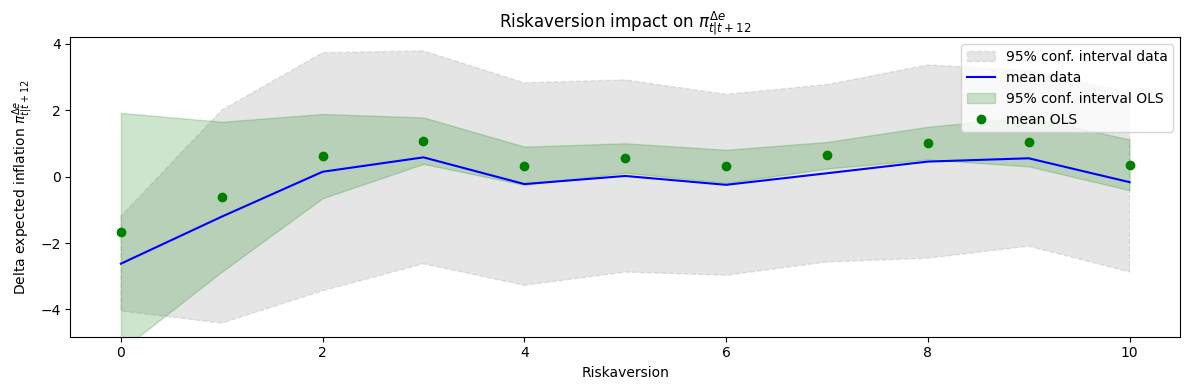

In [32]:
sub = ols_data2.loc[~ols_data2.riskaversion.isna()].copy()
sub = sub[['delta_pe_MY_error_act', 'riskaversion']].dropna()
sub = sub.groupby('riskaversion', observed=True).aggregate(['mean', 'std']).droplevel(0, axis=1)

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.fill_between(sub.index, sub['mean'] - 1.2 *  sub['std'], sub['mean'] + 1.2 *  sub['std'], alpha=.2, color='grey', 
                 label='95% conf. interval data', linestyle='dashed')
ax.plot(sub['mean'], color='blue', label='mean data')
y_lim = ax.get_ylim()

ax.fill_between(sub.index, sub2['conf_lower'], sub2['conf_upper'], color='green', alpha=.2, label='95% conf. interval OLS')
ax.plot(sub2['coef'].values, lw=0, marker='o', color='green', label='mean OLS')

ax.set_ylim(y_lim)

ax.legend()
ax.set_xlabel("Riskaversion")
ax.set_ylabel("Delta expected inflation $\pi^{\Delta e}_{t|t+12}$")
ax.set_title("Riskaversion impact on $\pi^{\Delta e}_{t|t+12}$")

fig.tight_layout()
save_fig(fig, "riskaversion.png")

# Macro Time Series Error analysis

## Test errors in time series dimension

In [43]:
for col in [('recorded', 'delta_pe_MY_error_act'), ('recorded', 'pi_perc_MY_all_error_act')]:

    sub = df[[f'date_{col[0]}', f'week_{col[0]}', 'id', col[1]]].drop_duplicates().dropna().groupby(f'week_{col[0]}')[col[1]].median().copy()
    sub /= 100
    df = pd_join_freq(df.set_index('date_recorded'), pd.DataFrame(sub.rename(f'{col[1]}_WY')), 'W', keep_left_index=True).copy()
    df = pd_join_freq(df, 
                     pd_groupby(pd.DataFrame(sub.rename(f'{col[1]}_MY')), [f'{col[1]}_MY'], 'M', 'last'),
                     'M', keep_left_index=True)
df = df.reset_index(drop=True)

In [44]:
arr = df.set_index('date_recorded').delta_pe_MY_error_act_WY.drop_duplicates().values 
arr = df.set_index('date_recorded').pi_perc_MY_all_error_act_WY.drop_duplicates().values 

In [45]:
arr = np.random.randn(100) / 100
arr1 = np.random.randn(100) / 100

In [46]:
# cross_corr(arr, arr1, lags=10);

## VECM error, perceived and expexcted

### pi perc

In [47]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()

In [48]:
cols_endog, cols_exog = ['pi_perc_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var1 = VAR(sub[cols_endog + cols_exog].diff().dropna()).fit(maxlags=2)
# print(var1.summary())

In [49]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=6)
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.bic).fit()
# vecm1.summary()

pi_perc_MY ADF p-val: 0.018553484289268035
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
2
6 6


In [50]:
# vecm1.irf(periods=5).plot()
# plt.tight_layout()
# ;

### pi perc error

In [51]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_MY_error_act',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [52]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var2 = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit(maxlags=2, ic='fpe')
# print(var1.summary())

In [53]:
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 7) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=6)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm2.summary()

pi_perc_MY_error_act ADF p-val: 4.59317633173586e-08
pi_de_surprise_Y ADF p-val: 0.2695181207003059
pi_de_estimate_Y ADF p-val: 0.7897732982121397
3
6 1


In [54]:
# vecm2.irf().plot()
# plt.tight_layout();

### delta exp

In [55]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [56]:
cols_endog, cols_exog = ['delta_pe_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=6)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.bic).fit()
# vecm3.summary()

delta_pe_MY ADF p-val: 0.44313200381795326
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
2
6 6


In [57]:
# vecm3.irf().plot()
# plt.tight_layout();

### delta exp error

In [58]:
sub = pd_join_freq(df.groupby('month_recorded')[['delta_pe_MY_error_act_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [59]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 6) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm4.summary()

delta_pe_MY_error_act_MY ADF p-val: 0.9509824412702439
pi_de_surprise_Y ADF p-val: 0.0535354526734725
pi_de_estimate_Y ADF p-val: 0.8029480317761679
2
5 1


### uncertainty

In [60]:
sub = pd_join_freq(df.groupby('month_recorded')[['pi_perc_uncertainty_MY',]].last().dropna().drop_duplicates(),
                   pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
                   'M', keep_left_index=False).drop_duplicates().dropna()
# sub.plot()

In [61]:
cols_endog, cols_exog = ['pi_perc_uncertainty_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 6) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=5)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()
# vecm5.summary()

pi_perc_uncertainty_MY ADF p-val: 0.0006861008216353449
pi_de_surprise_Y ADF p-val: 0.11112018851634486
pi_de_estimate_Y ADF p-val: 0.23711226517334416
1
5 1


In [63]:
# vecm5.irf().plot()
# plt.tight_layout();

### summary

In [78]:
lst_vecms = [vecm1, vecm2, vecm3, vecm4, vecm5]
_ = get_statsmodels_summary(lst_vecms, seperator=" ")
save_pd_df(_, 'tab_vecm_resid.csv', GRAPHS_DIR)

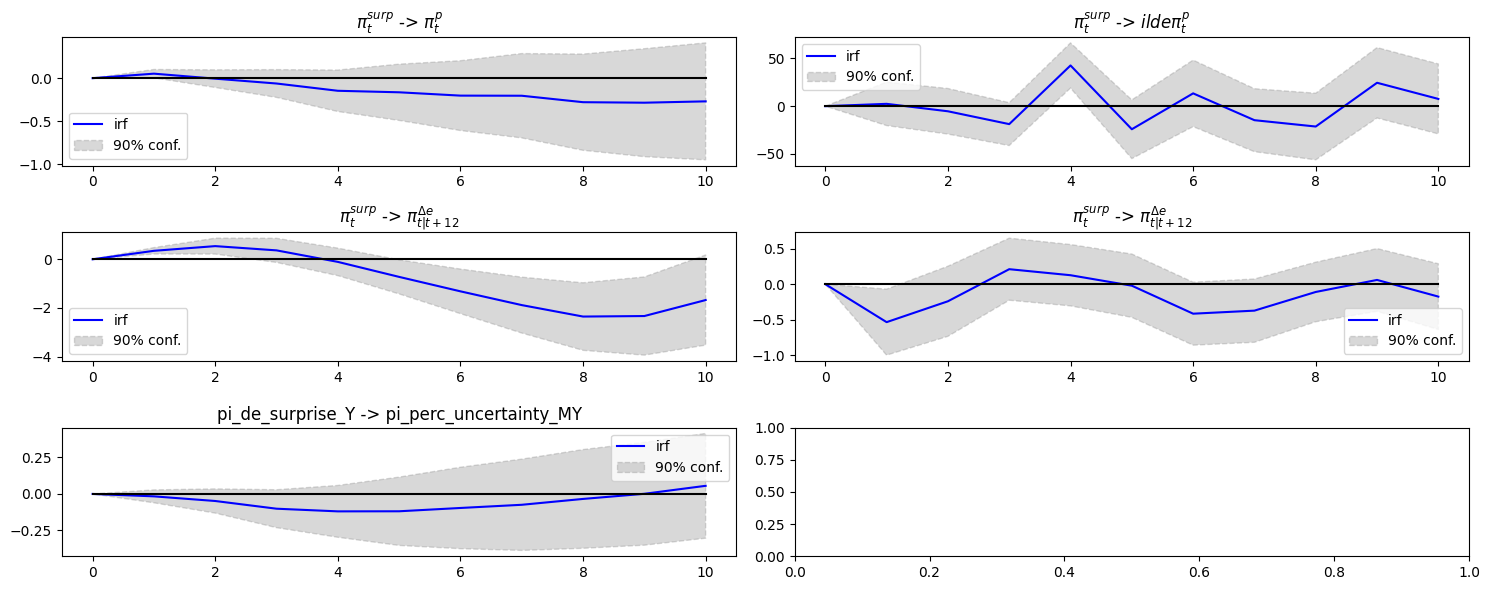

In [80]:
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "delta_pe_MY_error_act_MY": '$\pi^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\tilde{\pi}^p_{t}$",},
                            figsize=(5,3));
save_fig(fig, "emp_erro_vecm.png")

## VECM error, news, perceived and expexcted

### overview on news and narratives

In [82]:
sub = topics.drop(['M_policy',], axis=1).drop_duplicates().copy() #.iloc[:300]

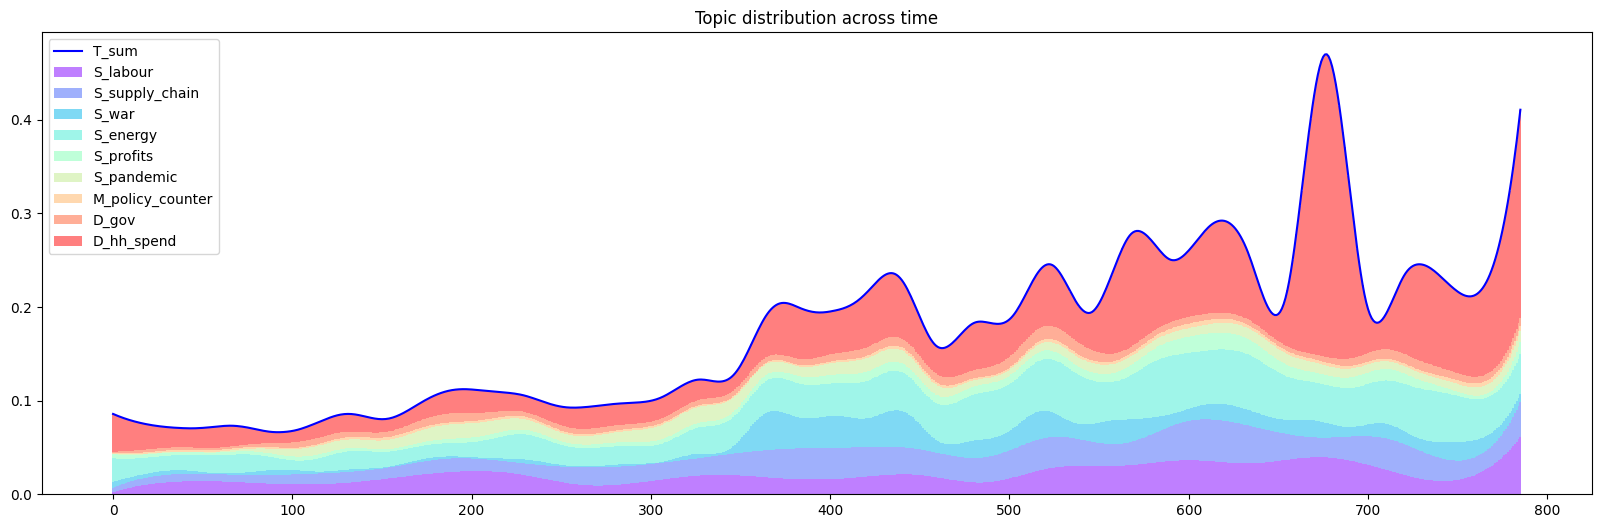

In [84]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1), )

ax.plot(sub.T_sum.values, color='blue', label='T_sum')
# ax.twinx().plot(sub.D_inflation.values, color='green', label='D_inflation')
ax.set_title("Topic distribution across time")
ax.legend(loc="upper left");
save_fig(fig, "topics_time.png")

''

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


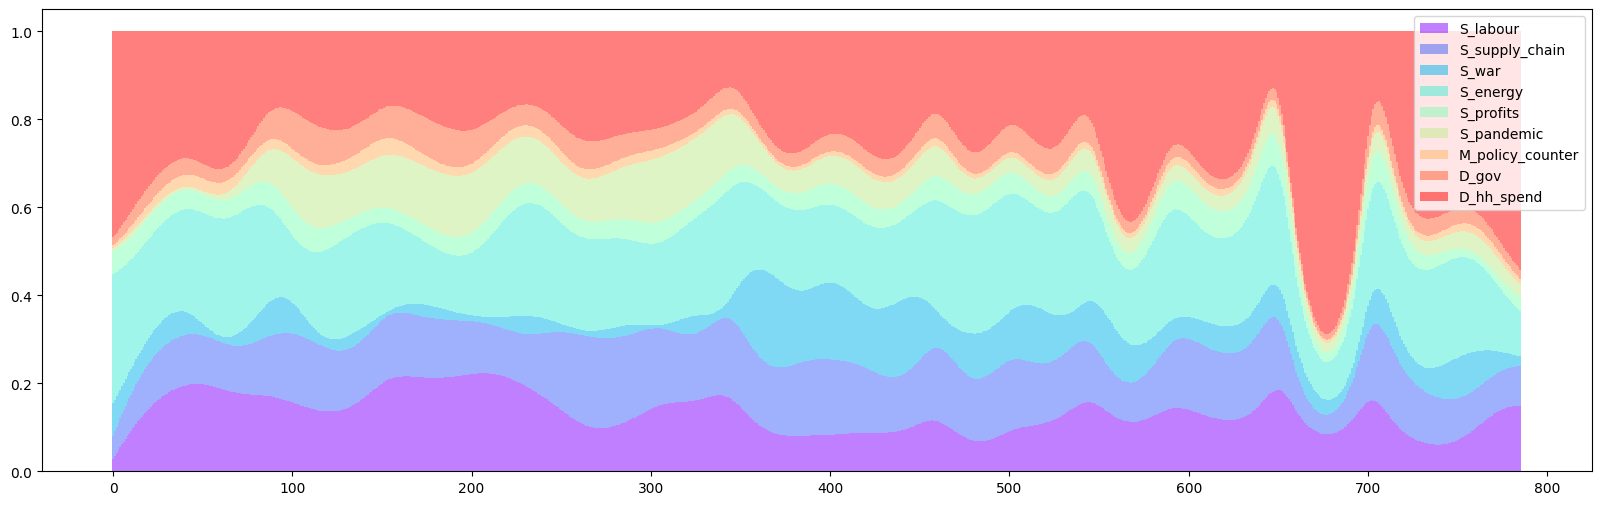

In [85]:
fig, ax = plt_stacked_bar(
    sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).apply(lambda x: x / x.sum(), axis=1)
)
ax.legend()
;

### war and inflation as given by hh concern

In [86]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, topics[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

cols_endog, cols_exog = ['S_war'], ['percprob_war']

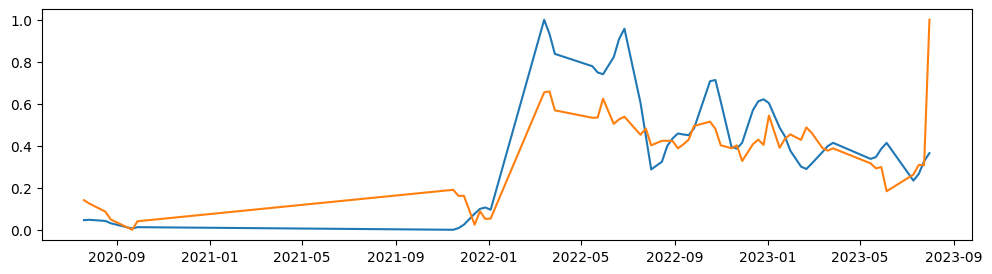

In [87]:
plt.plot(sub[cols_endog + cols_exog].apply(lambda x: min_max_scale(x)))
sub[cols_endog + cols_exog] = sub[cols_endog + cols_exog].apply(lambda x: min_max_scale(x))

In [88]:
var = VAR(sub[cols_endog + cols_exog].diff().dropna(),).fit(maxlags=2)
# print(var.summary())

## pi perc

In [96]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 ['pi_de_surprise_Y', 'delta_pe_MY', 'delta_pe_MY_error_act_MY', 'pi_perc_uncertainty_MY',
                  'pi_perc_MY_error_act', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
# sub.plot();
sub.shape

(34, 9)

In [90]:
cols_endog, cols_exog = ['pi_perc_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm1 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_MY ADF p-val: 0.01874377846322591
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_exp_MY ADF p-val: 0.14479079097337977
3
2 0


In [91]:
# vecm1.irf().plot()
# plt.tight_layout();

## pi perc error

In [92]:
cols_endog, cols_exog = ['pi_perc_MY_error_act'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm2 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_MY_error_act ADF p-val: 7.217927277626793e-08
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_exp_MY ADF p-val: 0.14479079097337977
4
2 0


## delta pe

In [93]:
cols_endog, cols_exog = ['delta_pe_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY',]

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm3 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

delta_pe_MY ADF p-val: 0.5619457365131322
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
pi_perc_MY ADF p-val: 0.01874377846322591
3
2 0


## delta pe error

In [99]:
cols_endog, cols_exog = ['delta_pe_MY_error_act_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=2)
print(var_order.aic, var_order.bic)

vecm4 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

delta_pe_MY_error_act_MY ADF p-val: 0.020658890361074964
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
2
2 0


## uncertainty

In [109]:
cols_endog, cols_exog = ['pi_perc_uncertainty_MY'], ['T_sum', 'pi_de_surprise_Y', 'pi_de_estimate_Y']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 2) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm5 = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=var_order.aic).fit()

pi_perc_uncertainty_MY ADF p-val: 0.0009126750943224087
T_sum ADF p-val: 0.9780580831132807
pi_de_surprise_Y ADF p-val: 0.10472588869867017
pi_de_estimate_Y ADF p-val: 0.6149615557812012
2
2 0


## summary

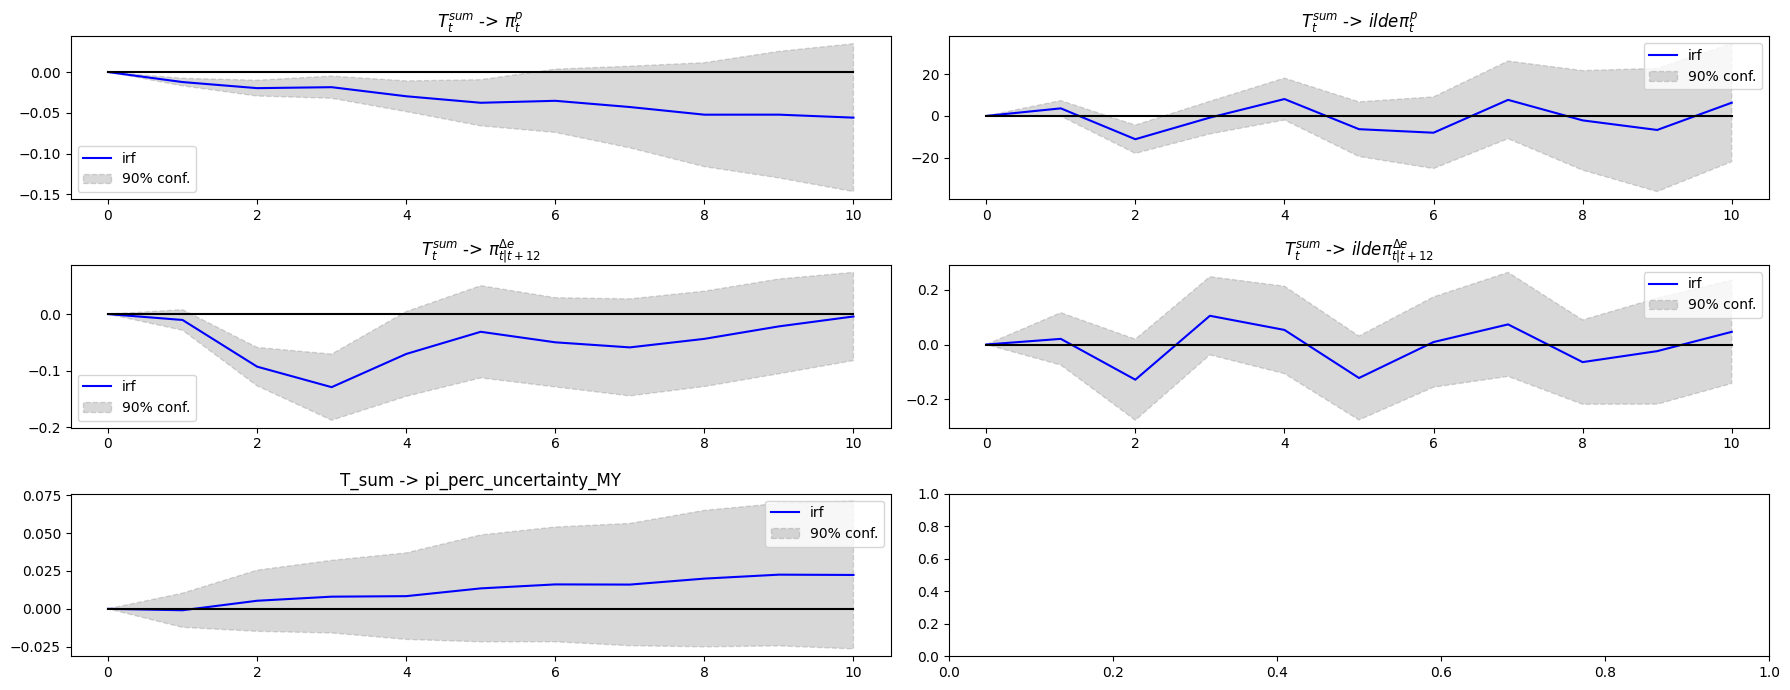

In [110]:
lst_vecms = [vecm1, vecm2, vecm3, vecm4, vecm5]
fig = get_multiple_vecm_irfs(lst_vecms,
                             dict_titles={'pi_de_surprise_Y': "$\pi^{surp}_t$", 
                                          "T_sum": "$T^{sum}_t$",
                                          "delta_pe_MY_error_act_MY": '$\tilde{\pi}^{\Delta e}_{t|t+12}$',
                                          "pi_perc_MY": "$\pi^p_t$", "delta_pe_MY": "$\pi^{\Delta e}_{t|t+12}$",
                                          "pi_perc_MY_error_act": "$\tilde{\pi}^p_{t}$",
                                         });
save_fig(fig, "emp_vecm_error_news.png")

In [111]:
_ = get_statsmodels_summary(lst_vecms,)
save_pd_df(_, 'tab_vecm_news_resid.csv', GRAPHS_DIR)

## without inflation

In [122]:
sub = df.groupby('week_recorded')[['pi_exp_WY', 'pi_perc_uncertainty_WY', 
                                   'delta_pe_WY', 'pi_perc_MY_all_error_act_WY', 'pi_perc_WY', 'T_sum']].last().dropna()
sub.shape

(91, 6)

In [123]:
cols_endog, cols_exog = ['pi_perc_uncertainty_WY'], ['T_sum', 'pi_perc_WY', 'delta_pe_WY']

for i in sub[cols_endog + cols_exog]:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_coint_rank(sub[cols_endog + cols_exog], -1, 5) # signif=0.05)
print(jtest.rank)

var_order = select_order(sub[cols_endog + cols_exog].diff().dropna(), maxlags=3)
print(var_order.aic, var_order.bic)

vecm = VECM(sub[cols_endog + cols_exog].dropna(), coint_rank=jtest.rank, k_ar_diff=1).fit()
# vecm.summary()

pi_perc_uncertainty_WY ADF p-val: 5.592176077492414e-06
T_sum ADF p-val: 0.9713187460871008
pi_perc_WY ADF p-val: 0.01849634003386648
delta_pe_WY ADF p-val: 0.8976540313298764
3
3 1


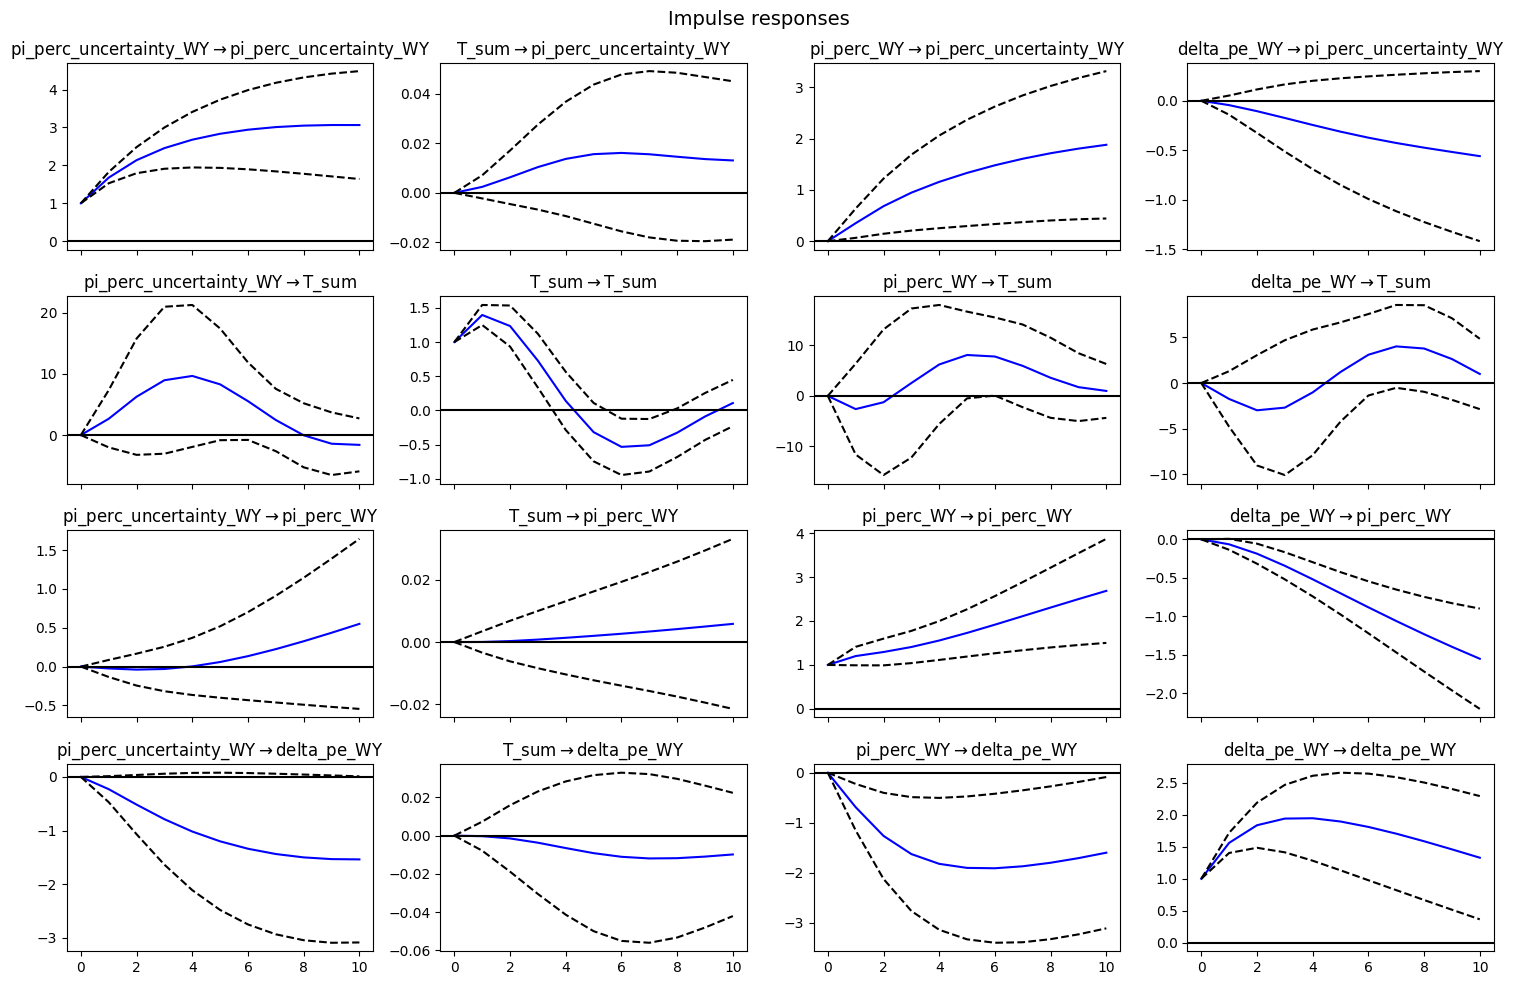

In [124]:
irf = vecm.irf()
irf.plot(figsize=(15,10))
plt.tight_layout()

## FECVD

Same analysis as Dräger (2015) as VAR to analyse:
$$ \hat{X}_t = \Gamma \hat{X}_{t-1} + u_t $$ 
where
$$X_t = (\hat{\pi}_t, \hat{\pi}^p_t, \hat{\pi}^e_{t-12}, \hat{N}_t), \quad \mbox{where} \quad \hat{z}_t = z_t - z_{t-1} $$

In [138]:
sub = pd_groupby(df.set_index('date_recorded'), 
                 [ 'pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
sub_d = sub.diff().dropna().copy()

In [141]:
var = VAR(sub).fit(ic='aic')
# var.summary()

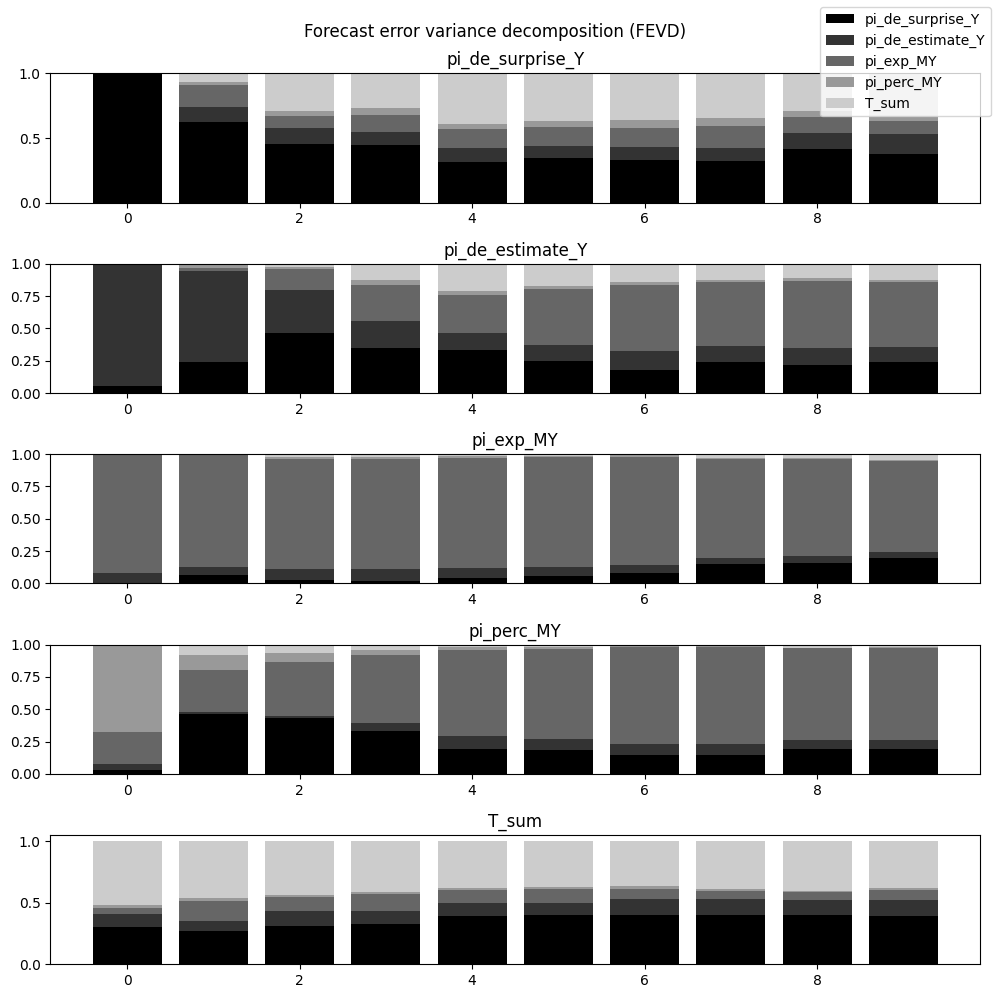

In [143]:
var.fevd().plot()
plt.tight_layout();

# Micro analysis

In [144]:
df_micro = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc',
    ]].copy(),
    pi[['pi_de_Y',  'pi_de_surprise_Y', 'pi_de_estimate_Y',]],
    'M',
    keep_left_index=True).copy()
df_micro = pd_join_freq(
    df_micro, 
    topics[['T_sum', 'T_sum_diff_lag']].drop_duplicates(), 
    "D", keep_left_index=True, how='left').sort_index()
df_micro['week_recorded'] = df_micro.date_forecast.dt.to_period('W').dt.to_timestamp()

In [145]:
df_micro['pi_perc_error'] = df_micro['pi_perc'] - df_micro.pi_de_Y
df_micro['delta_pe_error'] = df_micro['delta_pe'] - df_micro.pi_de_Y

In [146]:
_ = df[['pi_de_Y', 'pi_perc_WY']].apply(lambda x: x.iloc[1] - x.iloc[0], axis=1).copy().rename('pi_perc_error')
df['pi_perc_error'] = _

In [147]:
DICT_PARSE_COLS.update(
    {
        'T_pca_sum': float,
        'T_pca_sum_diff': float,
        'pi_de_surprise_Y': float,
        'pi_de_estimate_Y': float,
        'delta_pe_error': float,
    }
)

In [148]:
df_micro = pd_df_astype(df_micro, DICT_PARSE_COLS)

## panel structure sparsity and distance analysis

In [149]:
ind_cols = ['id', 'week_recorded']
sub = df[['pi_perc'] + ind_cols].copy().reset_index(drop=True).drop_duplicates()

filt = sub.groupby(ind_cols).pi_perc.last().unstack().count(axis=1) > 7
sub = sub.loc[sub.id.isin(list(filt[filt].index))].set_index(ind_cols).sort_index()
sub = sub.dropna()
filt.sum()

377

In [153]:
dist = df.groupby('id')[['hhinc_midpoint', 'pi_perc_error', 'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust']].last().astype(float)

dist = dist.loc[sub.index.get_level_values(0)]
dist = dist.loc[~dist.index.duplicated()]
dist = scipy.spatial.distance.cdist(dist, dist)

dist[np.isnan(dist)] = np.array(list([0] * np.isnan(dist).sum()))
dist = dist.mean(axis=0)

<AxesSubplot: xlabel='week_recorded', ylabel='id'>

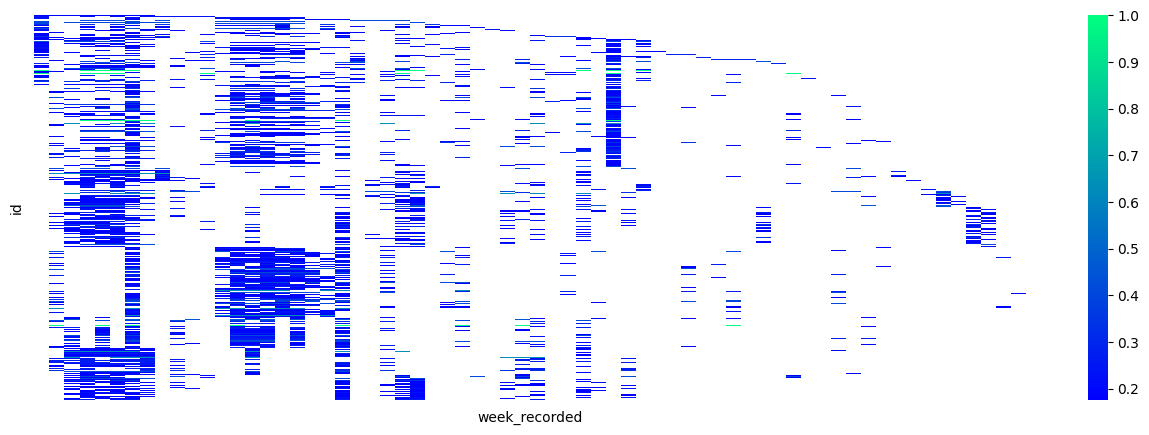

In [154]:
A = ~sub.unstack().isna()
A = (A * ((dist - dist.min()) / (dist.max() - dist.min()))[:, None]).replace({0: np.nan})
A.columns = A.columns.get_level_values(1)

fig = plt.figure(figsize=(16,5))
sns.heatmap(A, xticklabels=False, yticklabels=False, cmap='winter')

## POLS: How do news affect inflation perception on an individual level?

Investigate the effect of news $N_t$ on inflation perception $\pi^p_{i,t}$:
$$ \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [232]:
cols = ['T_sum_diff_lag', 'hhinc', 'pi_de_Y', 'is_unempl',] # 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc']

In [233]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((2960, 5), 473)

In [234]:
m_fe1 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                pi_perc   R-squared:                        0.2895
Estimator:                   PanelOLS   R-squared (Between):              0.7873
No. Observations:                2960   R-squared (Within):               0.2895
Date:                Thu, Apr 04 2024   R-squared (Overall):              0.7351
Time:                        12:26:04   Log-likelihood                    7352.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      67.149
Entities:                         473   P-value                           0.0000
Avg Obs:                       6.2579   Distribution:                 F(15,2472)
Min Obs:                       6.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             65.570
                            

In [235]:
# plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [236]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe1.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 41.507840400494935, 'LM p-val': 2.1097184954110038e-08, 'F-Stat': 10.506766994389825, 'F p-val': 1.883924310792313e-08}


In [237]:
durbin_watson_test_results = durbin_watson(m_fe1.resids) 
print(durbin_watson_test_results)

1.8239270248542483


In [238]:
# H0: RE is to be preferred
hausman(m_fe1, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: nan
degrees of freedom: 14
p-Value: nan


# Exp 2

Influence of news on future change in inflation $\pi^e_{i,t} - \pi^p_{i,t}$
$$ \pi^e_{i,t} - \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [239]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y', 'debt', 'is_unempl', 'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe']

In [240]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 3
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((2982, 7), 715)

In [241]:
m_fe2 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe2)

                          PanelOLS Estimation Summary                           
Dep. Variable:               delta_pe   R-squared:                        0.0701
Estimator:                   PanelOLS   R-squared (Between):             -39.745
No. Observations:                2982   R-squared (Within):               0.0701
Date:                Thu, Apr 04 2024   R-squared (Overall):             -7.2872
Time:                        12:26:20   Log-likelihood                    9203.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.1024
Entities:                         715   P-value                           0.0000
Avg Obs:                       4.1706   Distribution:                 F(33,2234)
Min Obs:                       4.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             9.9130
                            

In [242]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe2.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 459.8314818670349, 'LM p-val': 3.756190727093857e-96, 'F-Stat': 90.39831192346934, 'F p-val': 1.710028744352941e-104}


In [243]:
durbin_watson_test_results = durbin_watson(m_fe2.resids) 
print(durbin_watson_test_results)

2.175682693326379


In [244]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe2, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 45.32918702366133
degrees of freedom: 33
p-Value: 0.07474405395599985


# Exp 3

Influence of news on expectation:
$$ \pi^e_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [245]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_exp']

In [246]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((29619, 4), 4300)

In [248]:
m_fe3 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe3)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 pi_exp   R-squared:                        0.4400
Estimator:                   PanelOLS   R-squared (Between):              0.8173
No. Observations:               29619   R-squared (Within):               0.4400
Date:                Thu, Apr 04 2024   R-squared (Overall):              0.7721
Time:                        12:26:43   Log-likelihood                 7.752e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1420.1
Entities:                        4300   P-value                           0.0000
Avg Obs:                       6.8881   Distribution:                F(14,25305)
Min Obs:                       6.0000                                           
Max Obs:                       12.000   F-statistic (robust):             857.44
                            

In [249]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe3.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 120.74302357209334, 'LM p-val': 5.338384470369985e-26, 'F-Stat': 40.40695970550542, 'F p-val': 4.7570576316769013e-26}


In [250]:
durbin_watson_test_results = durbin_watson(m_fe3.resids) 
print(durbin_watson_test_results)

1.9877632815043527


In [251]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe3, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 53.64114406815968
degrees of freedom: 14
p-Value: 1.4793369997768898e-06


## Exp 4

In [254]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc_error']

In [255]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((8055, 4), 1492)

In [256]:
m_fe4 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe4)

                          PanelOLS Estimation Summary                           
Dep. Variable:          pi_perc_error   R-squared:                        0.3196
Estimator:                   PanelOLS   R-squared (Between):             -4.2491
No. Observations:                8055   R-squared (Within):               0.3196
Date:                Thu, Apr 04 2024   R-squared (Overall):             -0.8011
Time:                        12:27:04   Log-likelihood                 2.009e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      219.70
Entities:                        1492   P-value                           0.0000
Avg Obs:                       5.3988   Distribution:                 F(14,6549)
Min Obs:                       5.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             185.08
                            

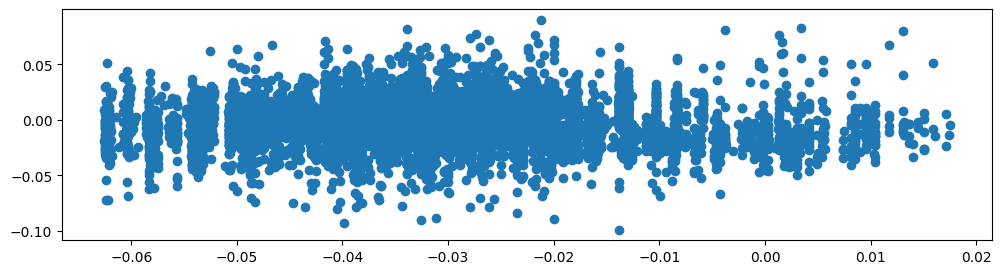

In [258]:
plt.scatter(m_fe4.predict().values, m_fe4.resids.values)

In [259]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe4.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 102.84736802964348, 'LM p-val': 3.7946980598407513e-22, 'F-Stat': 34.70859603799703, 'F p-val': 2.795240368143293e-22}


In [260]:
durbin_watson_test_results = durbin_watson(m_fe4.resids) 
print(durbin_watson_test_results)

2.002626697508108


In [261]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe4, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 44.45835045806109
degrees of freedom: 14
p-Value: 4.9926246987994546e-05


## Exp 5

In [262]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe_error']

In [263]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((45794, 4), 7279)

In [226]:
sub = sub.loc[~sub.duplicated()]

In [265]:
m_fe5 = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe5)

                          PanelOLS Estimation Summary                           
Dep. Variable:         delta_pe_error   R-squared:                        0.8714
Estimator:                   PanelOLS   R-squared (Between):              0.9921
No. Observations:               45794   R-squared (Within):               0.8714
Date:                Thu, Apr 04 2024   R-squared (Overall):              0.9767
Time:                        12:27:42   Log-likelihood                 1.449e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.863e+04
Entities:                        7279   P-value                           0.0000
Avg Obs:                       6.2912   Distribution:                F(14,38501)
Min Obs:                       5.0000                                           
Max Obs:                       12.000   F-statistic (robust):          2.994e+04
                            

In [266]:
# plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [267]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe5.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 2320.513963624378, 'LM p-val': 0.0, 'F-Stat': 814.7213706721717, 'F p-val': 0.0}


In [268]:
durbin_watson_test_results = durbin_watson(m_fe5.resids) 
print(durbin_watson_test_results)

1.4450538742600305


In [269]:
# H0: RE is to be preferred
hausman_results = hausman(m_fe5, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: -507.8429809431442
degrees of freedom: 14
p-Value: 1.0


## summary

In [270]:
lst_fes = [m_fe1, m_fe2, m_fe3, m_fe4, m_fe5]
get_statsmodels_summary(lst_fes,)

,pi_perc,delta_pe,pi_exp,pi_perc_error,delta_pe_error
T_sum_diff_lag,-0.342 ***\n[-4.774],1.186 ***\n[11.313],-0.078 ***\n[-2.683],-0.374 ***\n[-7.937],-0.246 ***\n[-17.764]
hhinc.10.0,0.006 \n[0.308],NaN,NaN,NaN,NaN
hhinc.11.0,0.013 \n[0.723],NaN,NaN,NaN,NaN
hhinc.12.0,0.014 \n[0.747],NaN,NaN,NaN,NaN
hhinc.13.0,0.009 \n[0.468],NaN,NaN,NaN,NaN
hhinc.2.0,0.005 \n[0.314],NaN,NaN,NaN,NaN
hhinc.3.0,0.005 \n[0.278],NaN,NaN,NaN,NaN
hhinc.4.0,-0.001 \n[-0.041],NaN,NaN,NaN,NaN
hhinc.5.0,-0.004 \n[-0.237],NaN,NaN,NaN,NaN
hhinc.6.0,0.0 \n[0.024],NaN,NaN,NaN,NaN
